# Predicting vertical streambed discharge from temperature measurements and differential pressure
## Learning Objectives

This tutorial is designed for advanced students at École Normale Supérieure to understand:

### 1. **Hydrogeophysical Modeling Fundamentals**
- **Stream-aquifer interactions**: Understanding how surface water and groundwater exchange heat and mass
- **Multi-physics coupling**: Learning how temperature, pressure, and flow are interconnected in porous media
- **Scale effects**: From laboratory to field-scale modeling approaches

### 2. **Mathematical Framework**
The Ginette model solves coupled partial differential equations:

**Heat Transport Equation:**
- Combines conductive heat transfer (Fourier's law) and advective heat transport
- Accounts for thermal properties of both water and sediment matrix
- Critical for understanding thermal signatures of groundwater flow

**Mass Balance Equation:**
- Darcy's law for fluid flow in porous media
- Pressure-driven flow with gravity effects
- Temperature-dependent viscosity and density effects

### 3. **Numerical Methods & Implementation**
- **Finite difference discretization**: Converting PDEs to algebraic equations
- **Grid generation**: Understanding spatial and temporal discretization
- **Boundary conditions**: Implementing physically realistic constraints
- **Parameter estimation**: Inverse modeling techniques for calibration

### 4. **Physical Parameters & Their Significance**

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Porosity | $n$ | Fraction of void space | 0.01 - 0.6 |
| Permeability | $k$ | Ease of fluid flow | $10^{-17}$ - $10^{-11}$ m² |
| Thermal conductivity | $\lambda$ | Heat conduction efficiency | 1 - 11 W/m°C |
| Heat capacity | $C$ | Energy storage capacity | 2000 - 4000 J/kg°C |

### 5. **Environmental Applications**
- **Climate change impacts**: Understanding how changing temperatures affect groundwater systems
- **Water resource management**: Quantifying stream-aquifer exchanges for sustainable use
- **Contaminant transport**: Using thermal tracers to understand pollutant pathways
- **Ecosystem services**: Stream temperature regulation by groundwater

### 6. **Data Analysis & Interpretation**
- **Time series analysis**: Understanding temporal patterns in temperature and pressure data
- **Profile interpretation**: Reading depth-dependent temperature and flow patterns
- **Model validation**: Comparing simulated and observed data
- **Sensitivity analysis**: Understanding parameter uncertainties

### 7. **Computational Skills Development**
- **Python programming**: Data manipulation with pandas, visualization with matplotlib
- **File I/O operations**: Reading/writing scientific data formats
- **Workflow automation**: Creating reproducible scientific analyses
- **Version control**: Best practices for collaborative scientific computing


This hands-on tutorial will prepare you for advanced research in environmental sciences, hydrology, and computational geophysics.


## **Mathematical Framework**
We will use `ginette` to predict streambed discharge from temperature measurements in real time.

You can find the `ginette` repository on GitHub: [ginette GitHub Repository](https://github.com/agnes-riviere/ginette)

Ginette models temperature by solving a two-dimensional, unsaturated and fully saturated form of the hydrologic energy transport equation [1]. In three dimensions, the equation is

$\frac{d}{dt} \left( \left[\phi {C}_w + \left( 1-\phi \right) {C}_{sed} \right] T \right) = \nabla \cdot \left( \lambda \nabla T \right) - \nabla \cdot \left( \phi {C}_w \vec{v} T \right)$,

where 
$t$ is time in s,
$\phi$ is porosity (a unitless fraction of total volume),
${C}_w$ is the volumetric specific heat capacity of water in J/m$^3$&deg;C,
${C}_{sed}$ is the volumetric specific heat capacity of the dry sediments in J/m$^3$&deg;C,
$T$ is temperature in &deg;C,
$\lambda$ is the thermal conductivity of the porous media in W/m&deg;C (4 models are available to take account ice, water, solid and air),
and $\vec{v}$ is the water velocity in m/s.


## Mass Balance Equation for Pore-Water Pressure

The mass balance equation used to calculate the pore-water pressure in the ($x$,$z$) plane is written:

$\frac{\partial}{\partial{x}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{x}}\right)\right) + \frac{\partial}{\partial{z}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{z}}+\rho_w g\right)\right) = \frac{S_{k}}{g} \frac{\partial{p}}{\partial{t}}  $

where 
- $t$ is time (s),
- $p$ is the pressure (Pa),
- $k$ is the intrinsic permeability ($m^{2}$),
- $k_{r}$(T,Sat) is the relative permeability,
- $g$ is the acceleration due to gravity (m\,$s^{-2}$),
- $\mu$ is the dynamic viscosity of water (Pa\,s),
- $\rho_{w}$ is the density of water (kg\,$m^{-3}$),
- $S_{k}$ is the specific storage coefficient ($m^{-1}$, see below).

The specific storage coefficient for fully saturated cells  is the specific storage coefficient $S_{s}$ in case of confined aquifer.

$S_{k}=S_{s}= \rho_{w} \, g \, n \, \left(\beta_f-\beta_s + \frac{\alpha_{c}}{ n }\right)$ , 

where 
- $n$ is the total porosity,
- $\beta_f$ is the compressibility of water ($Pa^{-1}$),
- $\beta_s$ is the compressibility of the solid rock grains ($Pa^{-1}$),
- $\alpha_c$ is the compressibility coefficient of the porous medium ($Pa^{-1}$).

For the unconfined aquifer, the specific storage coefficient is written:

$S_{k}=\frac{n_{d}}{e \, s_{w}}$,

with 
- $n_{d}$ the drainable porosity,
- $e$ the thickness of the grid cell (m),
- $s_{w}$ the saturation of  water.
  
The Richards equation is also implemented but we won"t use it.




In [55]:
import sys
import os

# Add the path to sys.path to access custom Python modules
# This allows us to import functions from the src_python directory
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')

# Standard scientific computing libraries
import numpy as np          # Numerical operations and array handling
from pathlib import Path    # Modern path handling
import pandas as pd         # Data manipulation and analysis
from scipy import interpolate  # Interpolation methods for data processing
import matplotlib.pyplot as plt  # Plotting and visualization
import matplotlib as mpl
from IPython.display import display  # For interactive notebook display
import subprocess          # For running external programs (Ginette executable)
import glob               # File pattern matching
import itertools          # Tools for creating iterators
import seaborn as sns     # Statistical data visualization
import array              # Array data structures

# Custom modules for Ginette modeling workflow
from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model       # Functions for setting up and running direct model
import Read_obs           # Functions for reading observational data
from Read_obs import process_obs_data
import Plot              # Visualization functions for model results
import importlib         # For reloading modules during development

# Import specific functions needed for the modeling workflow
from Direct_model import (
    setup_ginette,           # Initialize model geometry and parameters
    generate_zone_parameters, # Create heterogeneous material zones
    initial_conditions,      # Set initial temperature and pressure fields
    boundary_conditions,     # Apply boundary conditions (temperature, flow)
    run_direct_model,        # Execute the Ginette simulation
    remove_first_two_days    # Remove model spin-up period
)

# Import plotting functions for data visualization and model validation
from Plot import (
    plot_obs,                        # Plot raw observational data
    plot_obs_zoom,                   # Plot zoomed time series
    plot_compare_temperatures_obs_sim, # Compare observations vs simulations
    plot_temperatures_profiles,       # Plot temperature depth profiles
    plot_water_profiles_interpol,     # Plot water velocity fields
    plot_temperature_profiles_interpol, # Plot interpolated temperature fields
    plot_heat_flux_profiles_interpolated, # Plot heat flux components
    plot_fluxes_timeseries,          # Plot time series of exchanges
    plot_domain                      # Visualize model domain geometry
)

# Reload modules to ensure latest changes are loaded (useful during development)
importlib.reload(Direct_model)
importlib.reload(Plot)
importlib.reload(Read_obs)

# Set up directories and data paths
# This path contains the observational data (temperature sensors, pressure measurements)
Obs_data = '../OBS_point/Point1Touques/'

# Prepare Ginette working directories and compile the model if necessary
# This creates OUTPUT and SENSI folders and compiles the Fortran code
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/GINETTE_SENSI/')

Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/GINETTE_SENSI
Directory 'SENSI' already exists.
Directory 'OUTPUT' already exists.


# 1. Read observation data

## Understanding Field Data Collection

In hydrogeophysical studies, we collect multiple types of measurements to understand subsurface processes:

### **1.1 Types of Observational Data**

**Temperature Sensors (T1-T4):**
- **Purpose**: Measure temperature at different depths below the streambed
- **Depths**: Typically at -10 cm, -20 cm, -30 cm, and -40 cm
- **Physics**: Temperature variations indicate heat transport processes
- **Applications**: 
  - Identify groundwater flow direction (upward vs downward)
  - Quantify exchange rates between stream and aquifer
  - Validate thermal transport models

**Differential Pressure (ΔP):**
- **Purpose**: Measure pressure difference across the streambed interface
- **Physics**: Pressure gradients drive fluid flow according to Darcy's law
- **Units**: Typically in Pascals (Pa) or centimeters of water head
- **Applications**:
  - Determine hydraulic head gradients
  - Calculate vertical water fluxes
  - Identify flow reversals (gaining vs losing streams)

### **1.2 Data File Structure**

Our field data comes in two CSV files with different formats:
- `deltaP_Point1Touques_14_04_22.csv`: Pressure and one temperature measurement
- `Temp_Point1Touques_14_04_22.csv`: Multiple temperature sensors

### **1.3 Data Quality Considerations**

**Temporal Resolution:**
- Measurements every 15 minutes (900 seconds)
- Captures diurnal temperature cycles
- Sufficient for groundwater flow variations

**Spatial Resolution:**
- Sensors separated by 10 cm vertically
- Provides temperature gradient information
- Allows detection of thermal front propagation

**Data Challenges:**
- Different file formats require careful parsing
- Mixed date formats between files
- Potential data gaps or sensor malfunctions
- Need for quality control and interpolation

In [56]:
# =============================================================================
# SIMULATION SETUP: Define temporal parameters and read observational data
# =============================================================================
importlib.reload(Read_obs)
# Start date and time for the simulation
# This corresponds to when field measurements began
date_simul_bg = pd.to_datetime("2022/04/21 14:00:00")

# Simulation state configuration:
# 0 = steady state (time-independent, equilibrium conditions)
# 1 = transient state (time-dependent, dynamic evolution)
# We use transient state to capture temporal variations in temperature and flow
state = 1

# Data processing coefficients
coef = 0.01    # Scaling coefficient for pressure measurements
offset = 0  # Offset for pressure measurements (baseline correction)
# Simulation duration in days
# 30 days provides sufficient time to observe seasonal patterns and model spin-up
nb_day = 30

# List available CSV files in the observational data directory
print("CSV files in observational data directory:")
for file in glob.glob(os.path.join(Obs_data, '*.csv')):
    print(f"- {file}")

# Process observational data using the corrected function:
# - Reads temperature and pressure time series from CSV files with proper semicolon parsing
# - Interpolates to 15-minute intervals (matching model time step)
# - Applies quality control and filtering
# - Returns DataFrame with synchronized measurements
obs_temp = process_obs_data(Obs_data, date_simul_bg, coef, offset, nb_day)

print(f"\nObservational data loaded successfully:")
print(f"- Time period: {obs_temp.index.min()} to {obs_temp.index.max()}")
print(f"- Number of time steps: {len(obs_temp)}")
print(f"- Available measurements: {list(obs_temp.columns)}")
print(f"- Data shape: {obs_temp.shape}")

CSV files in observational data directory:
- ../OBS_point/Point1Touques/deltaP_Point1Touques_14_04_22.csv
- ../OBS_point/Point1Touques/Temp_Point1Touques_14_04_22.csv
Processing file: ../OBS_point/Point1Touques/deltaP_Point1Touques_14_04_22.csv
   #             dates    deltaP       T
0  1  14/04/2022 14:00 -7.975998  12.615
1  2  14/04/2022 14:15 -7.984793  12.690
2  3  14/04/2022 14:30 -7.993552  12.749
3  4  14/04/2022 14:45 -8.002275  12.846
4  5  14/04/2022 15:00 -8.010962  12.930
Processing file: ../OBS_point/Point1Touques/Temp_Point1Touques_14_04_22.csv
   ST2                dates      T1      T2      T3      T4
0    1  14/04/2022 14:00:00  10.528  10.392  10.211  10.096
1    2  14/04/2022 14:15:00  10.533  10.391  10.213  10.099
2    3  14/04/2022 14:30:00  10.582  10.392  10.214  10.119
3    4  14/04/2022 14:45:00  10.591  10.394  10.216  10.121
4    5  14/04/2022 15:00:00  10.602  10.397  10.216  10.124
Sample dates to convert: ['14/04/2022 14:00', '14/04/2022 14:15', '14/04/

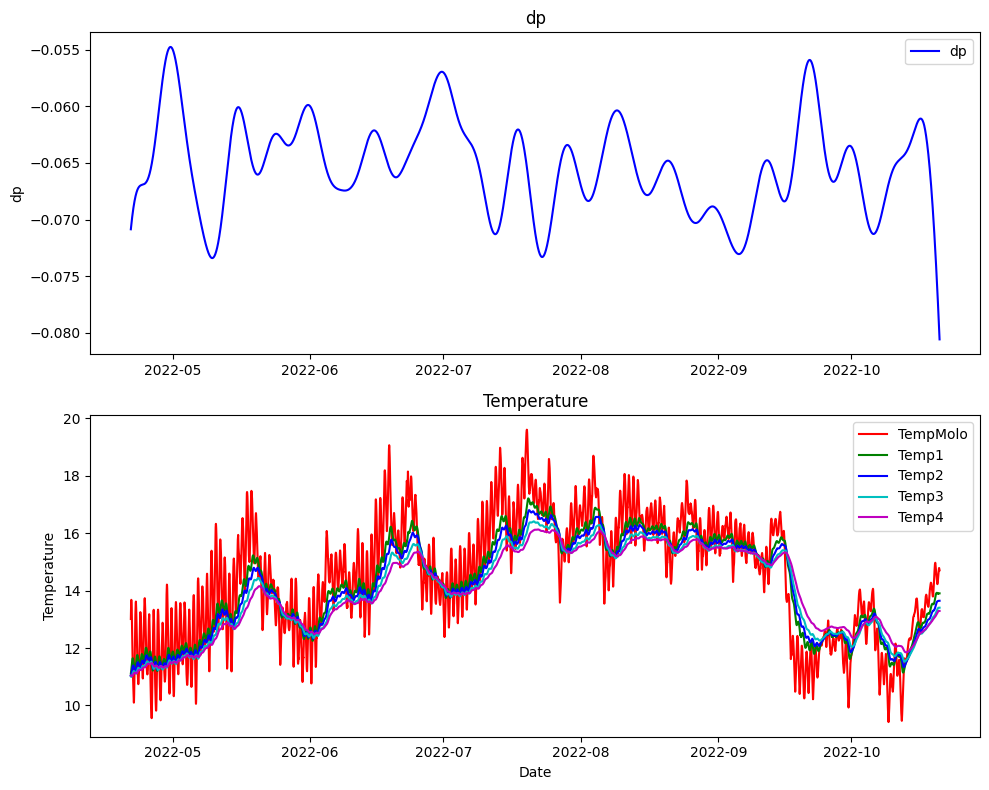

In [57]:
plot_obs(obs_temp)

## Zoom plot



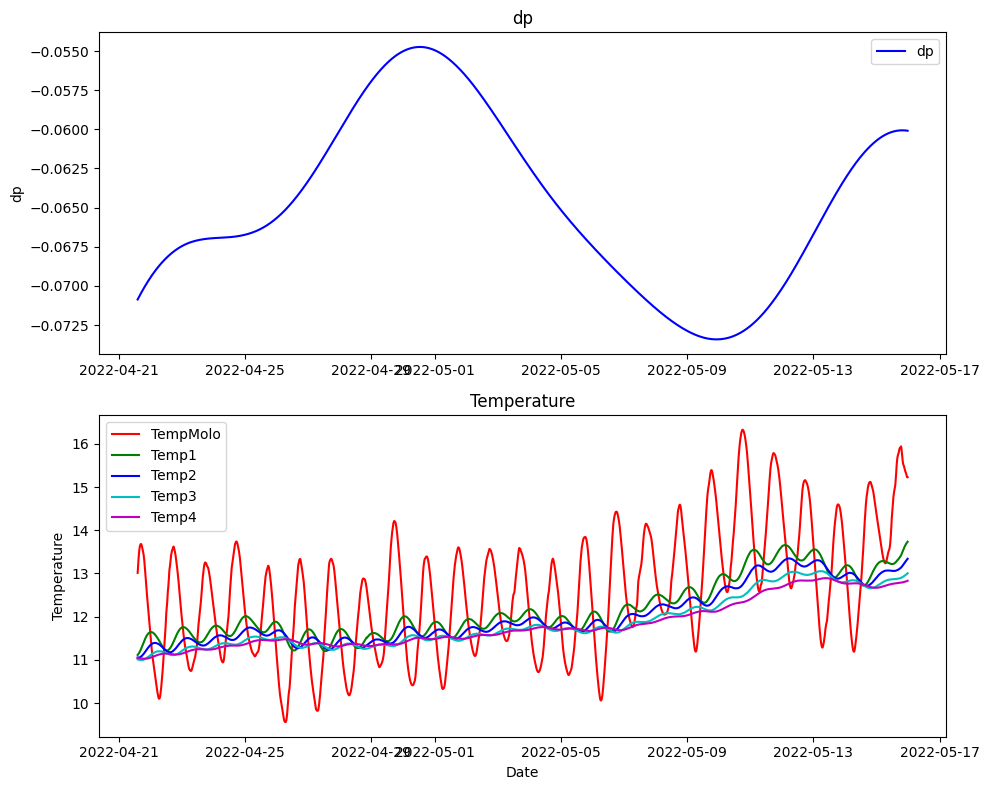

In [58]:
start_date = '2022-04-21'
end_date = '2022-05-16'

plot_obs_zoom(obs_temp, start_date, end_date)


# 2 DIRECT MODEL
Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 2.1 Initiation Ginette files

### ** Compilation**

### ** Model Files Generated**

The `setup_ginette()` function creates essential input files:

**Parameter Files:**
- `E_parametre.dat`: Core model configuration
- `E_p_therm.dat`: Thermal property parameters

**Grid Definition:**
- `E_coordonnee.dat`: Spatial coordinates for each cell
- `E_zone.dat`: Material zone assignments

**Observation Setup:**
- Defines exact depths where model outputs will be extracted
- Ensures spatial correspondence with field measurements

### ** Numerical Considerations**

**Why these specific values matter:**

1. **dt = 900s**: Captures diurnal temperature cycles (24 hours = 96 time steps)
2. **dz = 0.01m**: Resolves thermal boundary layer near streambed
3. **Domain depth = 0.4m**: Includes zone of significant stream influence
4. **Observation spacing**: Matches typical field deployment constraints




In [59]:
# =============================================================================
# MODEL GEOMETRY AND DISCRETIZATION SETUP
# =============================================================================

# Compile the Ginette Fortran executable if not already available
compile_ginette()

# TEMPORAL DISCRETIZATION
# Time step in seconds (900s = 15 minutes)
# This matches the measurement frequency and ensures numerical stability
dt = 900

# SPATIAL DOMAIN DEFINITION (1D vertical column)
z_top = 0.0      # Surface elevation (stream bed) [m]
z_bottom = -0.4  # Bottom of model domain [m] (40 cm below streambed)
az = abs(z_top - z_bottom)  # Total column height [m]

# GRID DISCRETIZATION
dz = 0.01        # Vertical cell size [m] (1 cm resolution)
                 # Fine discretization needed to capture thermal gradients

# OBSERVATION DEPTHS
dz_obs = 0.1     # Spacing between temperature sensors [m] (10 cm)
                 # Sensors at -10, -20, -30, -40 cm depths


nb_day = 30      # Simulation duration

# Initialize Ginette model files and return observation depths
# This function creates all necessary input files for the Ginette model:
# - Parameter files (E_parametre.dat)
# - Thermal parameter files (E_p_therm.dat)
# - Grid coordinates and observation points
z_obs = setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg, dz_obs)

print(f"Model domain setup:")
print(f"- Vertical extent: {z_top} to {z_bottom} m")
print(f"- Cell size: {dz} m")
print(f"- Number of cells: {int(az/dz)}")
print(f"- Time step: {dt} s ({dt/60} minutes)")
print(f"- Observation depths: {z_obs} m")

ginette exists
la simulation commence à 2022-04-21 14:00:00
Model domain setup:
- Vertical extent: 0.0 to -0.4 m
- Cell size: 0.01 m
- Number of cells: 40
- Time step: 900 s (15.0 minutes)
- Observation depths: [-0.1, -0.2, -0.30000000000000004, -0.4] m


## 2.2 Hydrogeological Parameters

### **Understanding Streambed Properties**

This section defines the physical properties that control how water and heat move through streambed sediments. These parameters are fundamental to understanding stream-aquifer interactions.

### **2.2.1 Why Use Two Zones?**

**Real streambed structure:**
- **Upper layer (0-32 cm)**
- **Lower layer (32-40 cm)**
- **Interface**



### **2.2.2 Key Physical Parameters**



In [60]:
# =============================================================================
# HYDROGEOLOGICAL PARAMETER DEFINITION
# =============================================================================

# GEOLOGICAL HETEROGENEITY
# Number of geological facies (material zones) in the column
# nb_zone = 1: Homogeneous porous medium
# nb_zone = 2: Two-layer system (typical for streambed environments)
nb_zone = 1

# Boundary between geological zones [m]
# Negative value indicates depth below streambed surface
alt_thk = -0.32  # Interface at 32 cm depth

# =============================================================================
# ZONE 1 PARAMETERS (Upper layer: 0 to -32 cm)
# Typically represents looser, more permeable streambed sediments
# =============================================================================

# POROSITY (φ) - Fraction of void space available for fluid flow
REF_n = 0.8  # High porosity typical of loose gravel/sand

# INTRINSIC PERMEABILITY (k) - Measure of medium's ability to transmit fluid
# Relationship: k = K·μ/(ρ·g) where:
# - K: hydraulic conductivity [m/s]
# - μ: dynamic viscosity [Pa·s]
# - ρ: fluid density [kg/m³]
# - g: gravitational acceleration [m/s²]
REF_k = -15  # Log₁₀(permeability in m²)
               # k = 10^(-13.5) ≈ 3.16×10^(-14) m²
               # Corresponds to coarse sand/fine gravel

# THERMAL CONDUCTIVITY (λ) - Heat conduction efficiency [W/m·K]
REF_l = 2.0    # Typical for water-saturated sediments

# SOLID GRAIN DENSITY (ρₛ) - Density of mineral grains [kg/m³]
REF_r = 3500   # Typical for quartz-rich sediments

# HEAT CAPACITY CALCULATION (handled internally by Ginette):
# c_pm = c_w·ρ_w·n·S + c_s·ρ_s·(1-n) + c_a·ρ_a·n·(1-S)
# where:
# - c_w = 4185 J/kg·°C (specific heat of water)
# - c_s = variable J/kg·°C (specific heat of solid)
# - S = saturation ratio
# - Fixed ρ_m = 1000 kg/m³ (imposed by Ginette)

# =============================================================================
# ZONE 2 PARAMETERS (Lower layer: -32 to -40 cm)
# Typically represents more compact, less permeable substrate
# =============================================================================

if nb_zone == 2:
    REF_n2 = 0.3    # Lower porosity (more compact sediment)
    REF_k2 = -13     # Higher permeability: k = 10^(-13) m²
    REF_l2 = 2.65    # Higher thermal conductivity (more mineral content)
    REF_r2 = 3500    # Same grain density (similar mineral composition)

print(f"Geological configuration:")
print(f"- Number of zones: {nb_zone}")
if nb_zone == 2:
    print(f"- Zone interface at: {alt_thk} m")
    print(f"- Zone 1 (upper): n={REF_n}, k=10^{REF_k} m², λ={REF_l} W/m·K")
    print(f"- Zone 2 (lower): n={REF_n2}, k=10^{REF_k2} m², λ={REF_l2} W/m·K")
else:
    print(f"- Homogeneous medium: n={REF_n}, k=10^{REF_k} m², λ={REF_l} W/m·K")

Geological configuration:
- Number of zones: 1
- Homogeneous medium: n=0.8, k=10^-15 m², λ=2.0 W/m·K


## 2.3 Initial and boundary conditions 

In [61]:
# =============================================================================
# INITIAL AND BOUNDARY CONDITIONS SETUP
# =============================================================================

# INITIAL CONDITIONS: Set starting temperature and pressure fields
# These represent the system state at t=0 (simulation start)
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)
# This function:
# 1. Interpolates measured temperatures to all grid cells
# 2. Creates initial pressure profile from surface pressure measurements
# 3. Writes E_temperature_initiale.dat and E_charge_initiale.dat

# BOUNDARY CONDITIONS: Define time-varying surface and bottom conditions
# Critical for realistic simulation of stream-aquifer interactions
boundary_conditions(obs_temp, dt)
# This function:
# 1. Sets surface temperature from stream measurements (time-varying)
# 2. Sets bottom temperature from deep sensor (less variable)
# 3. Sets surface pressure from differential pressure measurements
# 4. Sets bottom pressure boundary (typically fixed or gradient)
# 5. Writes E_cdt_aux_limites.dat, E_charge_t.dat, E_temp_t.dat

print("Initial and boundary conditions applied:")
print("- Initial temperature profile interpolated from observations")
print("- Initial pressure profile derived from surface measurements")
print("- Time-varying surface conditions from observational data")
print("- Bottom boundary conditions set for deep aquifer")

Initial and boundary conditions applied:
- Initial temperature profile interpolated from observations
- Initial pressure profile derived from surface measurements
- Time-varying surface conditions from observational data
- Bottom boundary conditions set for deep aquifer


/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/Direct_model.py:289: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lec_bc = lec_bc.replace('[valclt_haut]', format_value(all_data['TempMolo'][0]))
/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/Direct_model.py:290: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lec_bc = lec_bc.replace('[valclt_bas]', format_value(all_data['Temp4'][0]))
/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/Direct_model.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer k

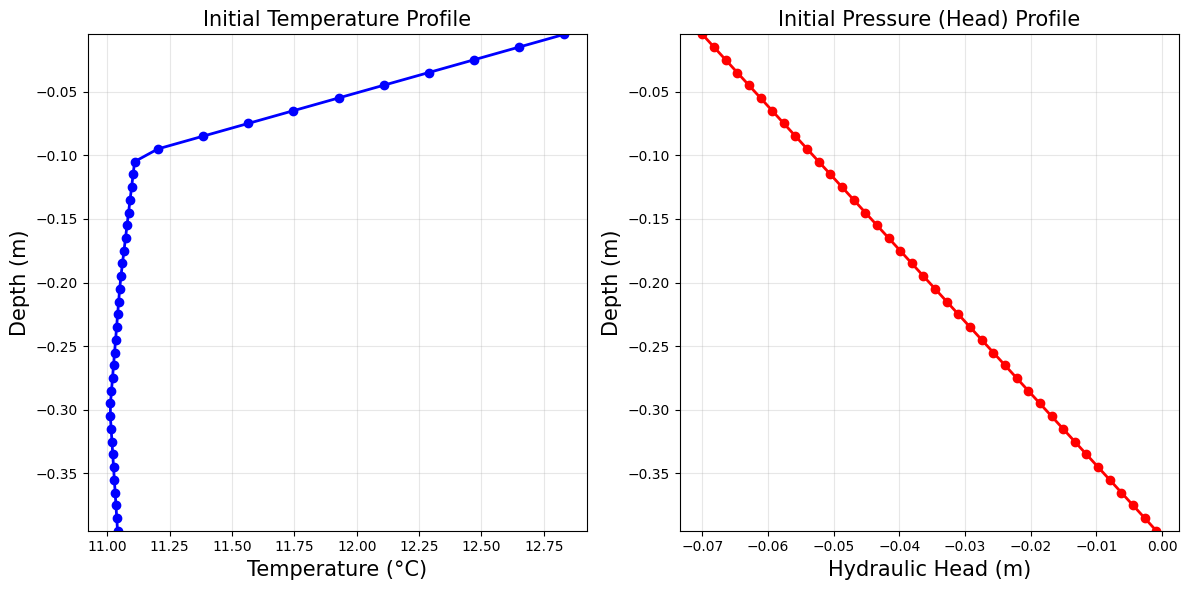

Initial Conditions Summary:
- Temperature range: 11.01 to 12.83 °C
- Hydraulic head range: -0.0700 to -0.0009 m
- Depth range: -0.40 to -0.01 m
- Number of grid cells: 40


In [62]:
# =============================================================================
# PLOT INITIAL CONDITIONS
# =============================================================================

# Import the new plotting function for initial conditions
from Plot import plot_initial_conditions

# Plot the initial temperature and pressure profiles
# This visualization helps verify that the initial conditions are realistic
# and properly interpolated from the observational data
plot_initial_conditions()

# The plots show:
# 1. Initial temperature profile: Interpolated from sensor measurements
# 2. Initial pressure profile: Derived from surface pressure measurements
# 
# These initial conditions serve as the starting point (t=0) for the simulation
# and should represent a reasonable approximation of the actual field conditions

In [63]:
# EXECUTE GINETTE SIMULATION
# Run appropriate model configuration based on geological complexity
if nb_zone == 1:
    # Homogeneous medium simulation
    sim_temp = run_direct_model(
        date_simul_bg, z_bottom, dz, nb_zone, alt_thk, 
        REF_k, REF_n, REF_l, REF_r, 
        REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None
    )
elif nb_zone == 2:
    # Heterogeneous two-zone simulation
    sim_temp = run_direct_model(
        date_simul_bg, z_bottom, dz, nb_zone, alt_thk, 
        REF_k, REF_n, REF_l, REF_r, 
        REF_k2=REF_k2, REF_n2=REF_n2, REF_l2=REF_l2, REF_r2=REF_r2
    )
print("Model execution completed:")
print(f"- Simulation period: {len(sim_temp)} time steps")
print(f"- Output variables: {list(sim_temp.columns)}")
# PARAMETER CONVERSION AND MODEL EXECUTION
# =============================================================================

# Ensure REF_k is in log scale before conversion


# Convert parameters from log-scale to linear scale for Ginette input
REF_k = 10**REF_k    # Convert log₁₀(permeability) to actual permeability [m²]
                     # REF_k = -13.5, so 10**(-13.5) = 3.16×10^(-14) m²
REF_l = REF_l        # Thermal conductivity already in correct units [W/m·K]
REF_n = REF_n        # Porosity already as fraction [dimensionless]
REF_r = REF_r        # Grain density already in correct units [kg/m³]

# Process second zone parameters if heterogeneous medium
if nb_zone == 2:
    REF_k2 = 10**REF_k2  # Convert second zone permeability
                         # REF_k2 = -13, so 10**(-13) = 1×10^(-13) m²
    REF_l2 = REF_l2      # Second zone thermal conductivity
    REF_n2 = REF_n2      # Second zone porosity
    REF_r2 = REF_r2      # Second zone grain density

print(f"- Parameter values used:")
if nb_zone == 1:
    print(f"  * Permeability: {REF_k:.2e} m²")
    print(f"  * Porosity: {REF_n}")
    print(f"  * Thermal conductivity: {REF_l} W/m·K")
else:
    print(f"  * Zone 1 - k: {REF_k:.2e} m², n: {REF_n}, λ: {REF_l} W/m·K")
    print(f"  * Zone 2 - k: {REF_k2:.2e} m², n: {REF_n2}, λ: {REF_l2} W/m·K")


 simu done
Model execution completed:
- Simulation period: 2880 time steps
- Output variables: ['Time', 'Temp1', 'Temp2', 'Temp3', 'dates']
- Parameter values used:
  * Permeability: 1.00e-15 m²
  * Porosity: 0.8
  * Thermal conductivity: 2.0 W/m·K


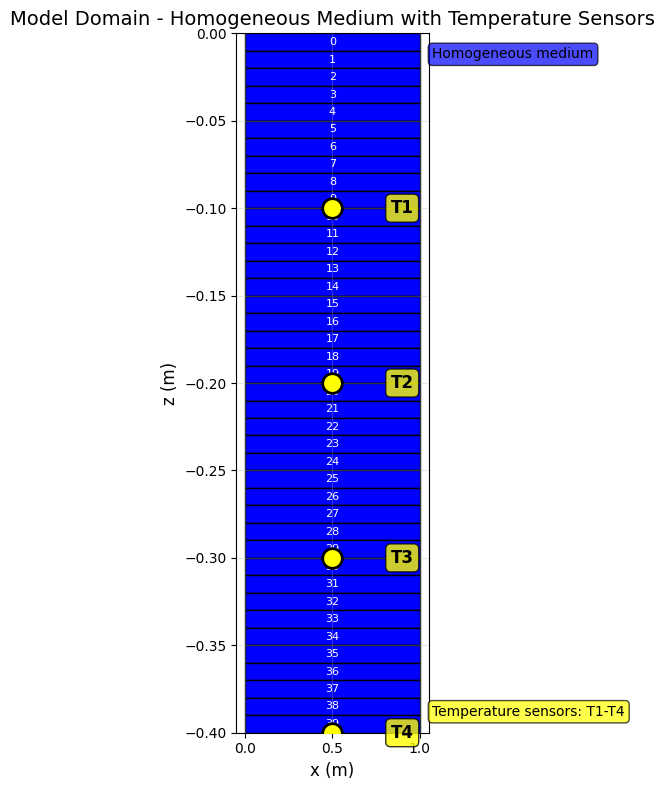

In [64]:
# =============================================================================
# MODEL DOMAIN VISUALIZATION
# =============================================================================
from Plot import plot_domain
# Visualize the geological structure of our streambed model
# This plot shows the physical layout and material properties of the model domain
# INCLUDING the positions of temperature sensors for better understanding

plot_domain(nb_zone=nb_zone, alt_thk=alt_thk, z_top=z_top, z_bottom=z_bottom, z_obs=z_obs)

# FUNCTION PARAMETERS EXPLAINED:
# -------------------------------
# nb_zone    : Number of geological zones (1 = homogeneous, 2 = two-layer system)
# alt_thk    : Altitude/depth of the interface between zones [m] 
#              (only relevant when nb_zone = 2)
# z_top      : Top elevation of the model domain [m] (streambed surface = 0.0)
# z_bottom   : Bottom elevation of the model domain [m] (deepest point = -0.4)
# z_obs      : Observation depths where temperature sensors are located [m]
#              Shows exact positions of T1, T2, T3, T4 sensors


## 2.4 warmup period 2 days

In [65]:
# =============================================================================
# MODEL SPIN-UP REMOVAL
# =============================================================================

# Remove the first 2-4 days from both simulated and observed data
# This eliminates the "warm-up" or "spin-up" period where:
# 1. Initial conditions may not be perfectly representative
# 2. Numerical artifacts can affect early simulation results
# 3. The model needs time to reach equilibrium with boundary conditions

# The spin-up period is critical in subsurface modeling because:
# - Initial temperature fields are interpolated estimates
# - Initial pressure fields may not be in perfect equilibrium
# - Transient effects from imperfect initial conditions need time to dissipate

sim_temp, obs_temp = remove_first_two_days(sim_temp, obs_temp)

print("Spin-up period removed:")
print(f"- Simulation data: {len(sim_temp)} time steps remaining")
print(f"- Observational data: {len(obs_temp)} time steps remaining")
print(f"- Analysis period: {sim_temp['dates'].min()} to {sim_temp['dates'].max()}")

# After spin-up removal, the data represents the system in quasi-equilibrium
# with realistic boundary conditions, providing more reliable model validation

Spin-up period removed:
- Simulation data: 2497 time steps remaining
- Observational data: 17114 time steps remaining
- Analysis period: 2022-04-25 14:00:00 to 2022-05-21 14:00:00


## 2.5. Comparaison Obs Sim

In [66]:
sim_temp.head()

,Time,Temp1,Temp2,Temp3,dates
383,345600.0,11.661414,11.699786,11.615915,2022-04-25 14:00:00
384,346500.0,11.674530,11.696595,11.615177,2022-04-25 14:15:00
385,347400.0,11.689099,11.693705,11.614378,2022-04-25 14:30:00
386,348300.0,11.705081,11.691134,11.613524,2022-04-25 14:45:00
387,349200.0,11.722391,11.688903,11.612622,2022-04-25 15:00:00


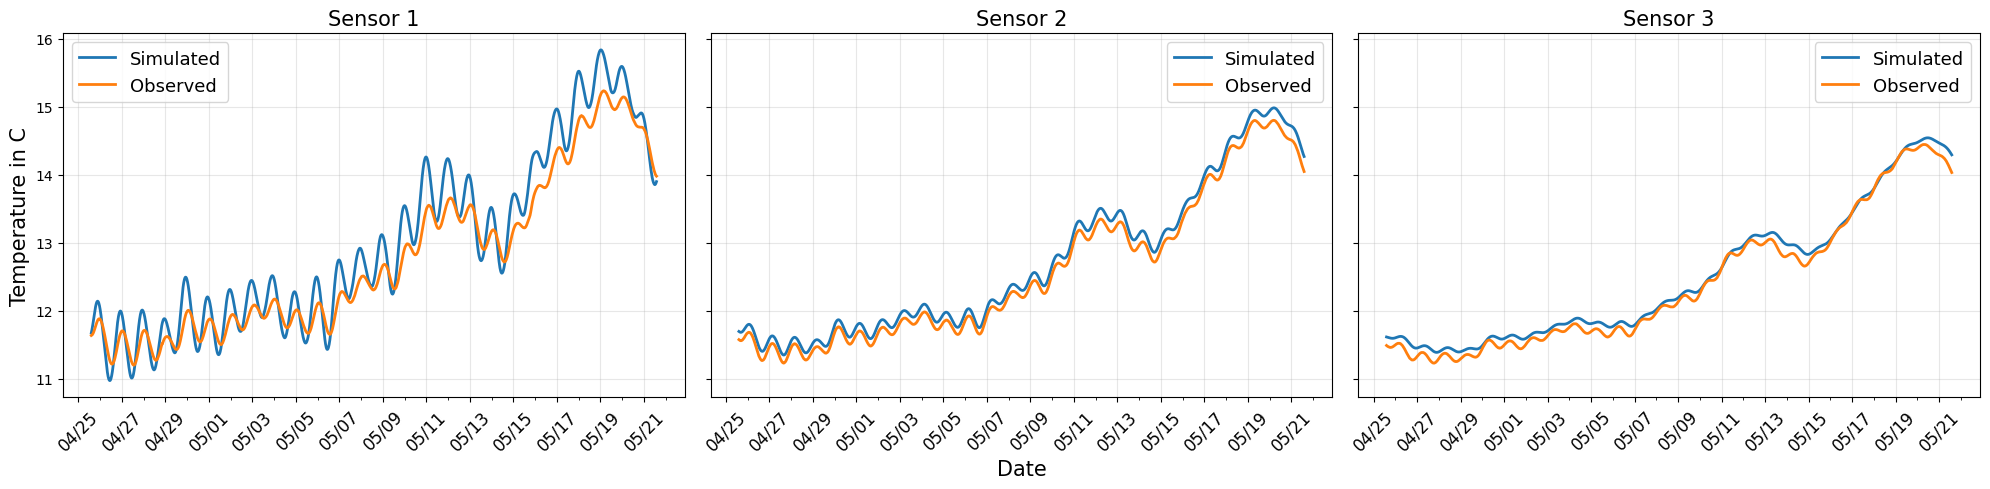

Model validation analysis:
- Compare amplitude and phase of temperature oscillations
- Assess temperature damping with depth
- Evaluate model performance at each sensor depth


In [67]:
# =============================================================================
# MODEL VALIDATION: COMPARISON OF OBSERVATIONS vs SIMULATIONS
# =============================================================================

# Create comparative plots showing observed vs simulated temperatures
# This is crucial for model validation and parameter assessment
plot_compare_temperatures_obs_sim(sim_temp, obs_temp)

# Model validation metrics to consider:
# 1. VISUAL INSPECTION:
#    - Do simulated and observed curves follow similar trends?
#    - Are diurnal (daily) temperature cycles captured?
#    - Are seasonal trends reproduced?
#    - Is the phase lag between sensors realistic?

# 2. QUANTITATIVE METRICS (can be calculated separately):
#    - Root Mean Square Error (RMSE)
#    - Nash-Sutcliffe Efficiency (NSE)
#    - Coefficient of determination (R²)
#    - Mean Absolute Error (MAE)

# 3. PHYSICAL INTERPRETATION:
#    - Temperature damping with depth (heat attenuation)
#    - Phase shifts between shallow and deep sensors
#    - Amplitude reduction in temperature oscillations

print("Model validation analysis:")
print("- Compare amplitude and phase of temperature oscillations")
print("- Assess temperature damping with depth")
print("- Evaluate model performance at each sensor depth")

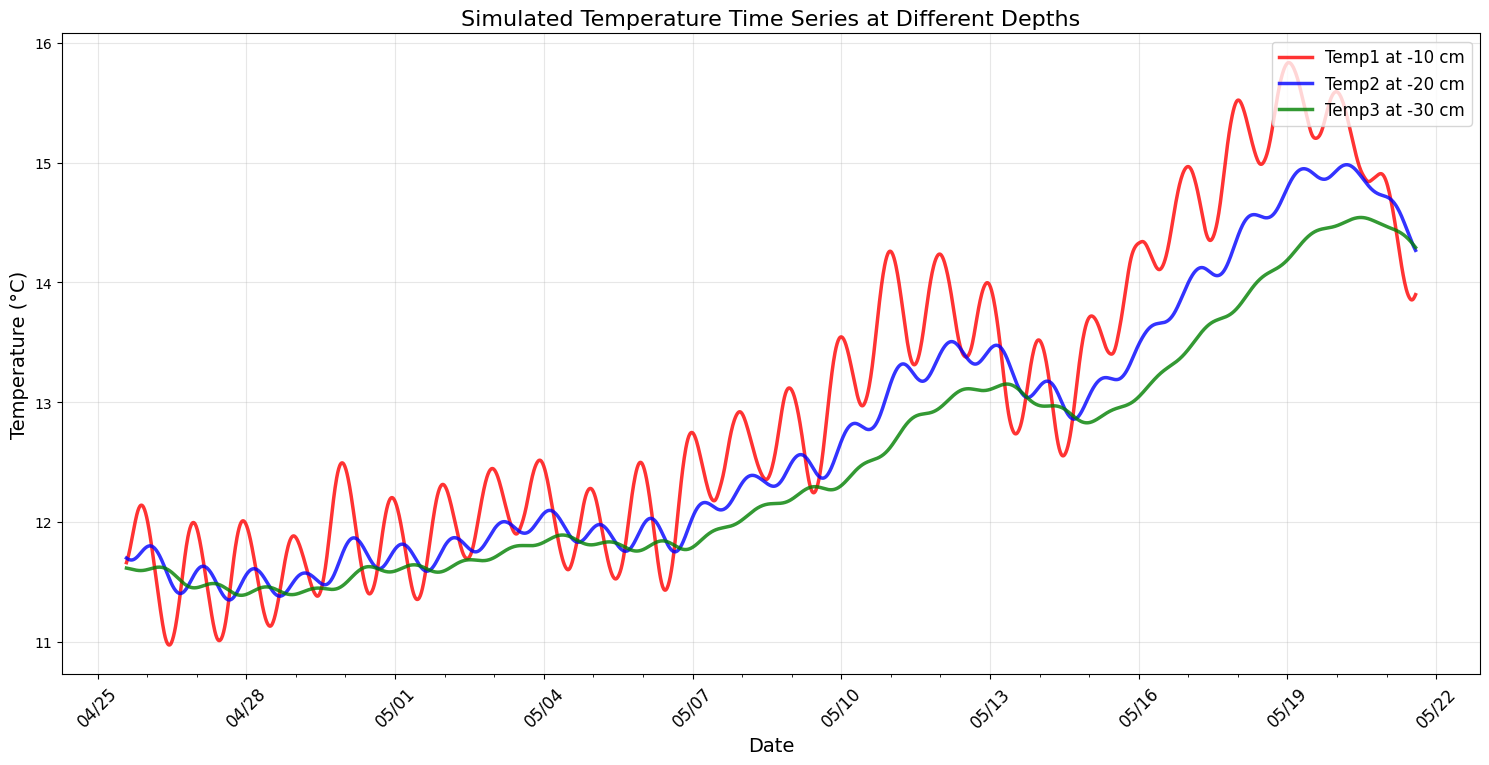

In [68]:
# =============================================================================
# PLOT SIMULATED TEMPERATURE TIME SERIES
# =============================================================================

# Alternative: Create a single plot with all sensors on the same graph
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a single plot for all temperature sensors
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Use sim_temp directly since it should already have a datetime index after spin-up removal
sim_temp_plot = sim_temp.copy()

# Temperature sensors and their depths for labeling
temp_sensors = ['Temp1', 'Temp2', 'Temp3']
sensor_depths = ['-10 cm', '-20 cm', '-30 cm']
colors = ['red', 'blue', 'green']

# Plot all sensors on the same subplot
for i, (sensor, depth, color) in enumerate(zip(temp_sensors, sensor_depths, colors)):
    if sensor in sim_temp_plot.columns:
        ax.plot(sim_temp_plot.index, sim_temp_plot[sensor], 
                color=color, linewidth=2.5, label=f'{sensor} at {depth}', alpha=0.8)

# Configure the plot
ax.set_ylabel('Temperature (°C)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Simulated Temperature Time Series at Different Depths', fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='upper right')

# Format x-axis dates to prevent overlap
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

# Rotate x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Add space for rotated labels
plt.show()


In [69]:
# =============================================================================
# EVALUATE MODEL PERFORMANCE WITH STATISTICAL CRITERIA
# =============================================================================
# Import statistical functions for model evaluation
from stat_critere import rmse, mae, bias, nse, kge, d_index,   correlation_coefficient, calculate_all_metrics, categorize_performance


# =============================================================================
# PERFORMANCE EVALUATION FOR EACH TEMPERATURE SENSOR
# =============================================================================

print("\n" + "="*80)
print("EVALUATION DES PERFORMANCES DU MODELE GINETTE")
print("Comparaison des temperatures simulees vs observees")
print("="*80)

# Dictionary to store all performance metrics
all_performance_metrics = {}

# Temperature sensors to evaluate (corresponding to different depths)
temp_sensors = ['Temp1', 'Temp2', 'Temp3']
sensor_depths = {
    'Temp1': '-10 cm',
    'Temp2': '-20 cm', 
    'Temp3': '-30 cm'
}

# Evaluate performance for each temperature sensor
for sensor in temp_sensors:
    if sensor in sim_temp.columns and sensor in obs_temp.columns:
        print(f"\nANALYSE CAPTEUR {sensor} (profondeur: {sensor_depths[sensor]})")
        print("-" * 60)
        
        # Extract simulated and observed data for this sensor
        # Ensure both datasets have the same index for proper alignment
        
        # Get common time index between simulation and observations
        common_index = sim_temp.index.intersection(obs_temp.index)
        
        if len(common_index) == 0:
            print(f"No common time periods between simulation and observations for {sensor}")
            continue
            
        # Extract data for common time periods only
        sim_data = sim_temp.loc[common_index, sensor].values
        obs_data = obs_temp.loc[common_index, sensor].values
        
        print(f"Data alignment check:")
        print(f"   Simulation data length: {len(sim_data)}")
        print(f"   Observation data length: {len(obs_data)}")
        print(f"   Common time periods: {len(common_index)}")
        
        # Remove NaN values from aligned datasets
        valid_mask = ~(np.isnan(sim_data) | np.isnan(obs_data))
        sim_clean = sim_data[valid_mask]
        obs_clean = obs_data[valid_mask]
        
        if len(sim_clean) < 10:
            print(f"Insufficient valid data points for {sensor}: {len(sim_clean)}")
            continue
        
        # Calculate comprehensive metrics
        try:
            metrics = calculate_all_metrics(sim_clean, obs_clean)
            if metrics is not None:
                all_performance_metrics[sensor] = metrics
                
                # Display key metrics
                print(f"Performance metrics:")
                print(f"   RMSE (Root Mean Square Error):     {metrics['RMSE']:.3f} degrees C")
                print(f"   MAE (Mean Absolute Error):         {metrics['MAE']:.3f} degrees C")
                print(f"   NSE (Nash-Sutcliffe Efficiency):   {metrics['NSE']:.3f}")
                print(f"   R squared (Coefficient of determination): {metrics['R_squared']:.3f}")
                print(f"   KGE (Kling-Gupta Efficiency):      {metrics['KGE']:.3f}")
                print(f"   PBIAS (Percent Bias):              {metrics['PBIAS']:+.1f}%")
                print(f"   Correlation (r):                   {metrics['R']:.3f}")
                print(f"   Number of valid points:            {metrics['n_points']}")
                
                # Performance categorization
                performance_cat = categorize_performance(
                    nse_val=metrics['NSE'], 
                    r2_val=metrics['R_squared'], 
                    kge_val=metrics['KGE']
                )
                print(f"   OVERALL EVALUATION: {performance_cat}")
                
        except Exception as e:
            print(f"Error calculating metrics for {sensor}: {e}")
            # Fallback to basic calculations
            rmse_val = np.sqrt(np.mean((sim_clean - obs_clean)**2))
            mae_val = np.mean(np.abs(sim_clean - obs_clean))
            r_val = np.corrcoef(sim_clean, obs_clean)[0,1] if len(sim_clean) > 1 else 0
            
            print(f"Basic metrics:")
            print(f"   RMSE: {rmse_val:.3f} degrees C")
            print(f"   MAE:  {mae_val:.3f} degrees C") 
            print(f"   R:    {r_val:.3f}")

# =============================================================================
# OVERALL MODEL PERFORMANCE SUMMARY
# =============================================================================

if all_performance_metrics:
    print(f"\n" + "="*80)
    print("RESUME GLOBAL DES PERFORMANCES")
    print("="*80)
    
    # Calculate mean performance across all sensors
    mean_metrics = {}
    for metric in ['RMSE', 'NSE', 'R_squared', 'KGE', 'PBIAS']:
        values = [sensor_metrics[metric] for sensor_metrics in all_performance_metrics.values() 
                 if metric in sensor_metrics and not np.isnan(sensor_metrics[metric])]
        if values:
            mean_metrics[f'mean_{metric}'] = np.mean(values)
            mean_metrics[f'std_{metric}'] = np.std(values)
    
    # Display overall statistics
    if mean_metrics:
        print(f"AVERAGES ACROSS ALL SENSORS:")
        print(f"   Mean RMSE:  {mean_metrics.get('mean_RMSE', 0):.3f} +/- {mean_metrics.get('std_RMSE', 0):.3f} degrees C")
        print(f"   Mean NSE:   {mean_metrics.get('mean_NSE', 0):.3f} +/- {mean_metrics.get('std_NSE', 0):.3f}")
        print(f"   Mean R squared:    {mean_metrics.get('mean_R_squared', 0):.3f} +/- {mean_metrics.get('std_R_squared', 0):.3f}")
        print(f"   Mean KGE:   {mean_metrics.get('mean_KGE', 0):.3f} +/- {mean_metrics.get('std_KGE', 0):.3f}")
        print(f"   Mean PBIAS: {mean_metrics.get('mean_PBIAS', 0):+.1f} +/- {mean_metrics.get('std_PBIAS', 0):.1f}%")
        
        # Overall model assessment
        overall_nse = mean_metrics.get('mean_NSE', -999)
        overall_r2 = mean_metrics.get('mean_R_squared', 0)
        overall_kge = mean_metrics.get('mean_KGE', -999)
        
        try:
            overall_category = categorize_performance(overall_nse, overall_r2, overall_kge)
            print(f"\nOVERALL MODEL PERFORMANCE: {overall_category}")
        except:
            print(f"\nOVERALL PERFORMANCE: Not determined")

# =============================================================================
# SUMMARY TABLE CREATION
# =============================================================================

if all_performance_metrics:
    print(f"\n" + "="*80)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*80)
    
    # Table header
    print(f"{'Sensor':<8} {'Depth':<10} {'RMSE':<6} {'R squared':<10} {'NSE':<6} {'PBIAS':<8} {'KGE':<6}")
    print("-" * 80)
    
    # Rows for each sensor
    for sensor, metrics in all_performance_metrics.items():
        depth = sensor_depths.get(sensor, 'Unknown')
        rmse_val = metrics.get('RMSE', 0)
        r2_val = metrics.get('R_squared', 0)
        nse_val = metrics.get('NSE', 0)
        pbias_val = metrics.get('PBIAS', 0)
        kge_val = metrics.get('KGE', 0)
        
        print(f"{sensor:<8} {depth:<10} {rmse_val:.3f}  {r2_val:.3f}      {nse_val:.3f}  {pbias_val:+6.1f}%  {kge_val:.3f}")
    
    print("-" * 80)




EVALUATION DES PERFORMANCES DU MODELE GINETTE
Comparaison des temperatures simulees vs observees

ANALYSE CAPTEUR Temp1 (profondeur: -10 cm)
------------------------------------------------------------
Data alignment check:
   Simulation data length: 2496
   Observation data length: 2496
   Common time periods: 2496
Performance metrics:
   RMSE (Root Mean Square Error):     0.340 degrees C
   MAE (Mean Absolute Error):         0.283 degrees C
   NSE (Nash-Sutcliffe Efficiency):   0.913
   R squared (Coefficient of determination): 0.967
   KGE (Kling-Gupta Efficiency):      0.883
   PBIAS (Percent Bias):              +1.7%
   Correlation (r):                   0.983
   Number of valid points:            2496
   OVERALL EVALUATION: Excellent

ANALYSE CAPTEUR Temp2 (profondeur: -20 cm)
------------------------------------------------------------
Data alignment check:
   Simulation data length: 2496
   Observation data length: 2496
   Common time periods: 2496
Performance metrics:
   RMSE

## 2.6. plot temperature profiles

/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/Plot.py:335: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


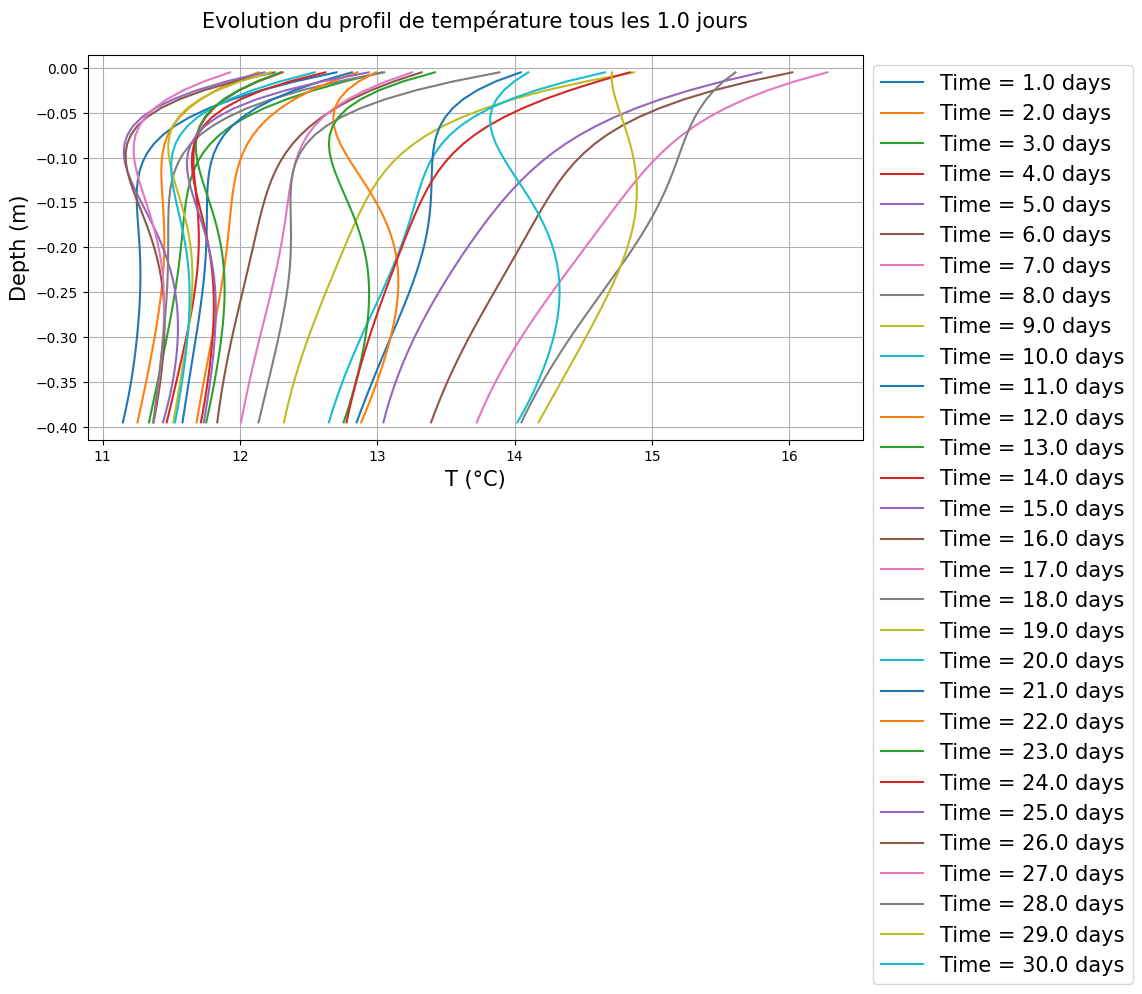

In [70]:
plot_temperatures_profiles(interval=86400)

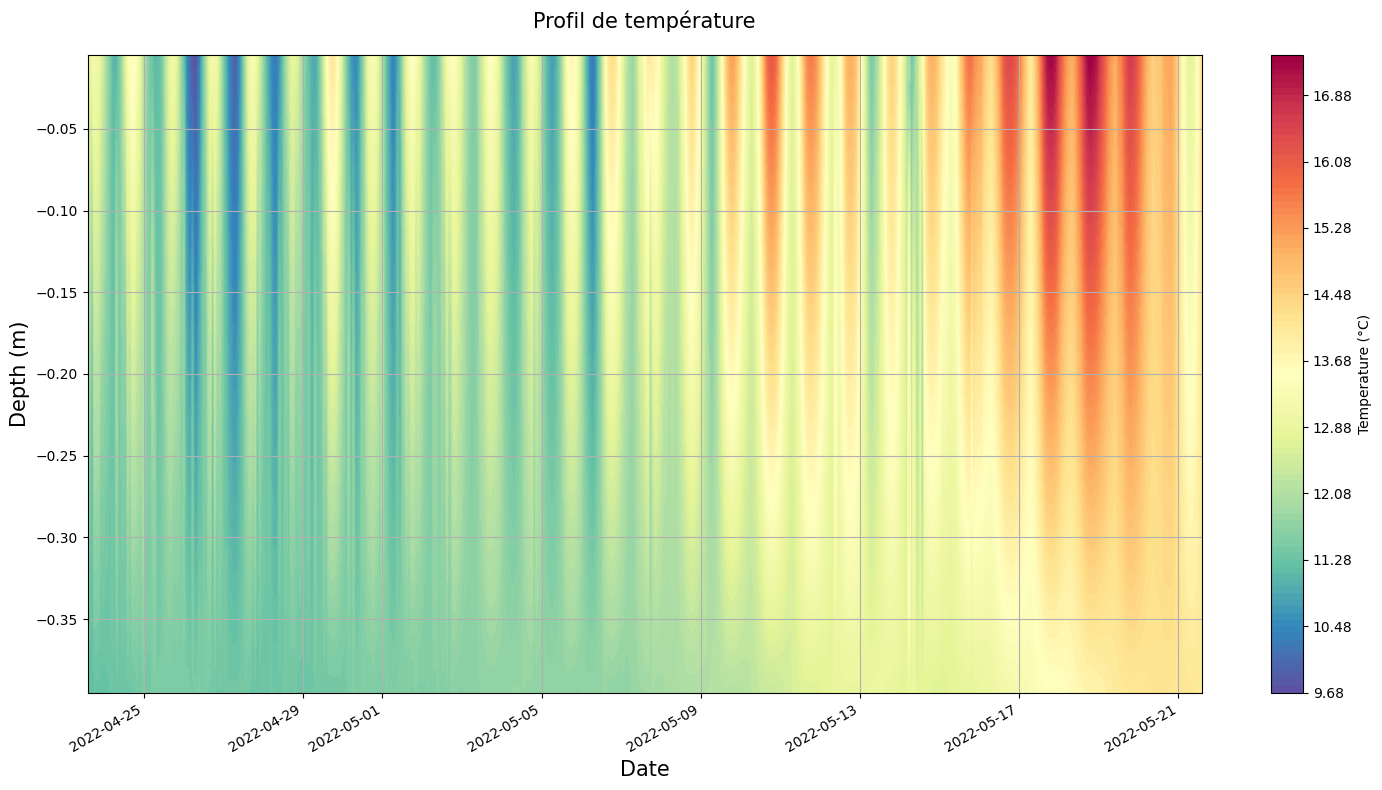

In [71]:
plot_temperature_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

# 2.7. plot the water stream-aquifer exchanges

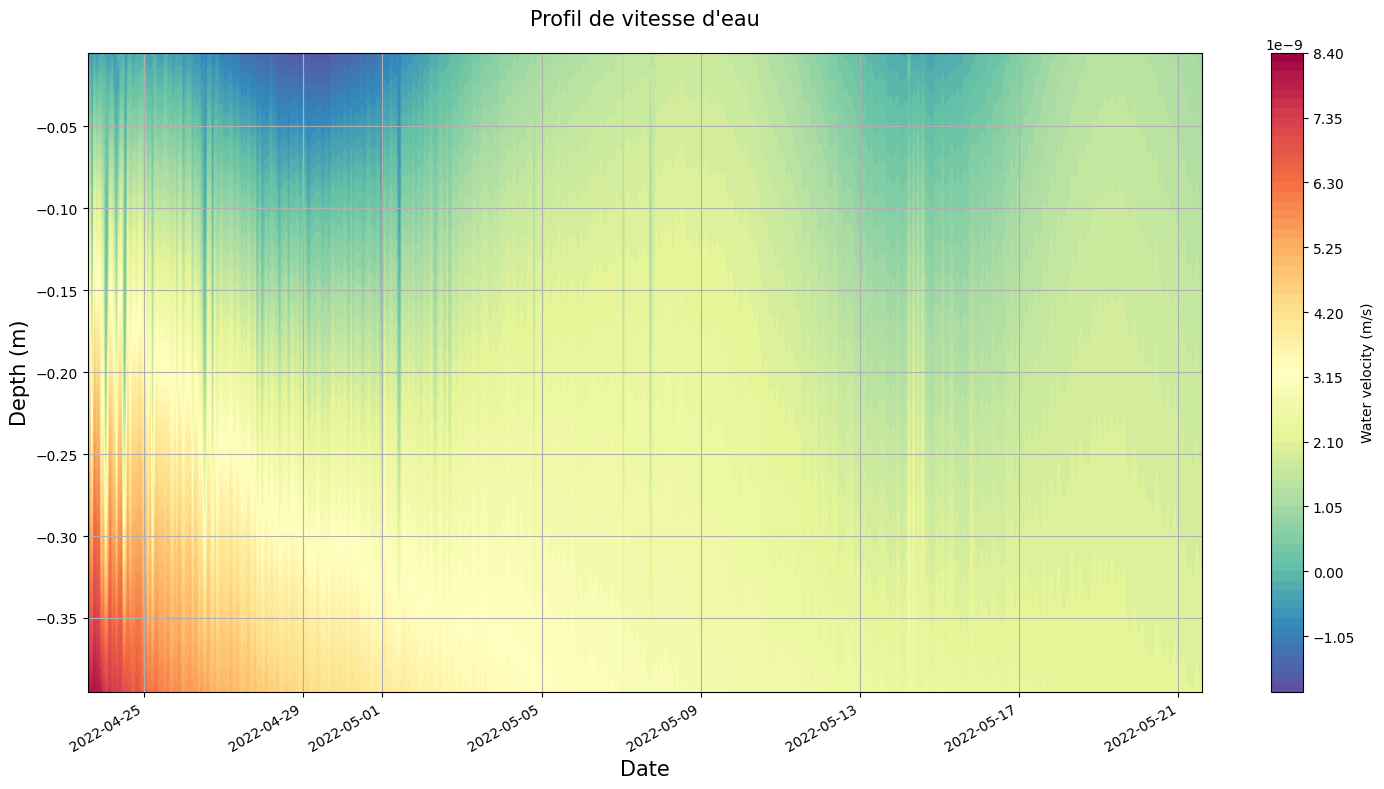

In [72]:
plot_water_profiles_interpol(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

# 2.8. plot the heat stream-aquifer exchanges

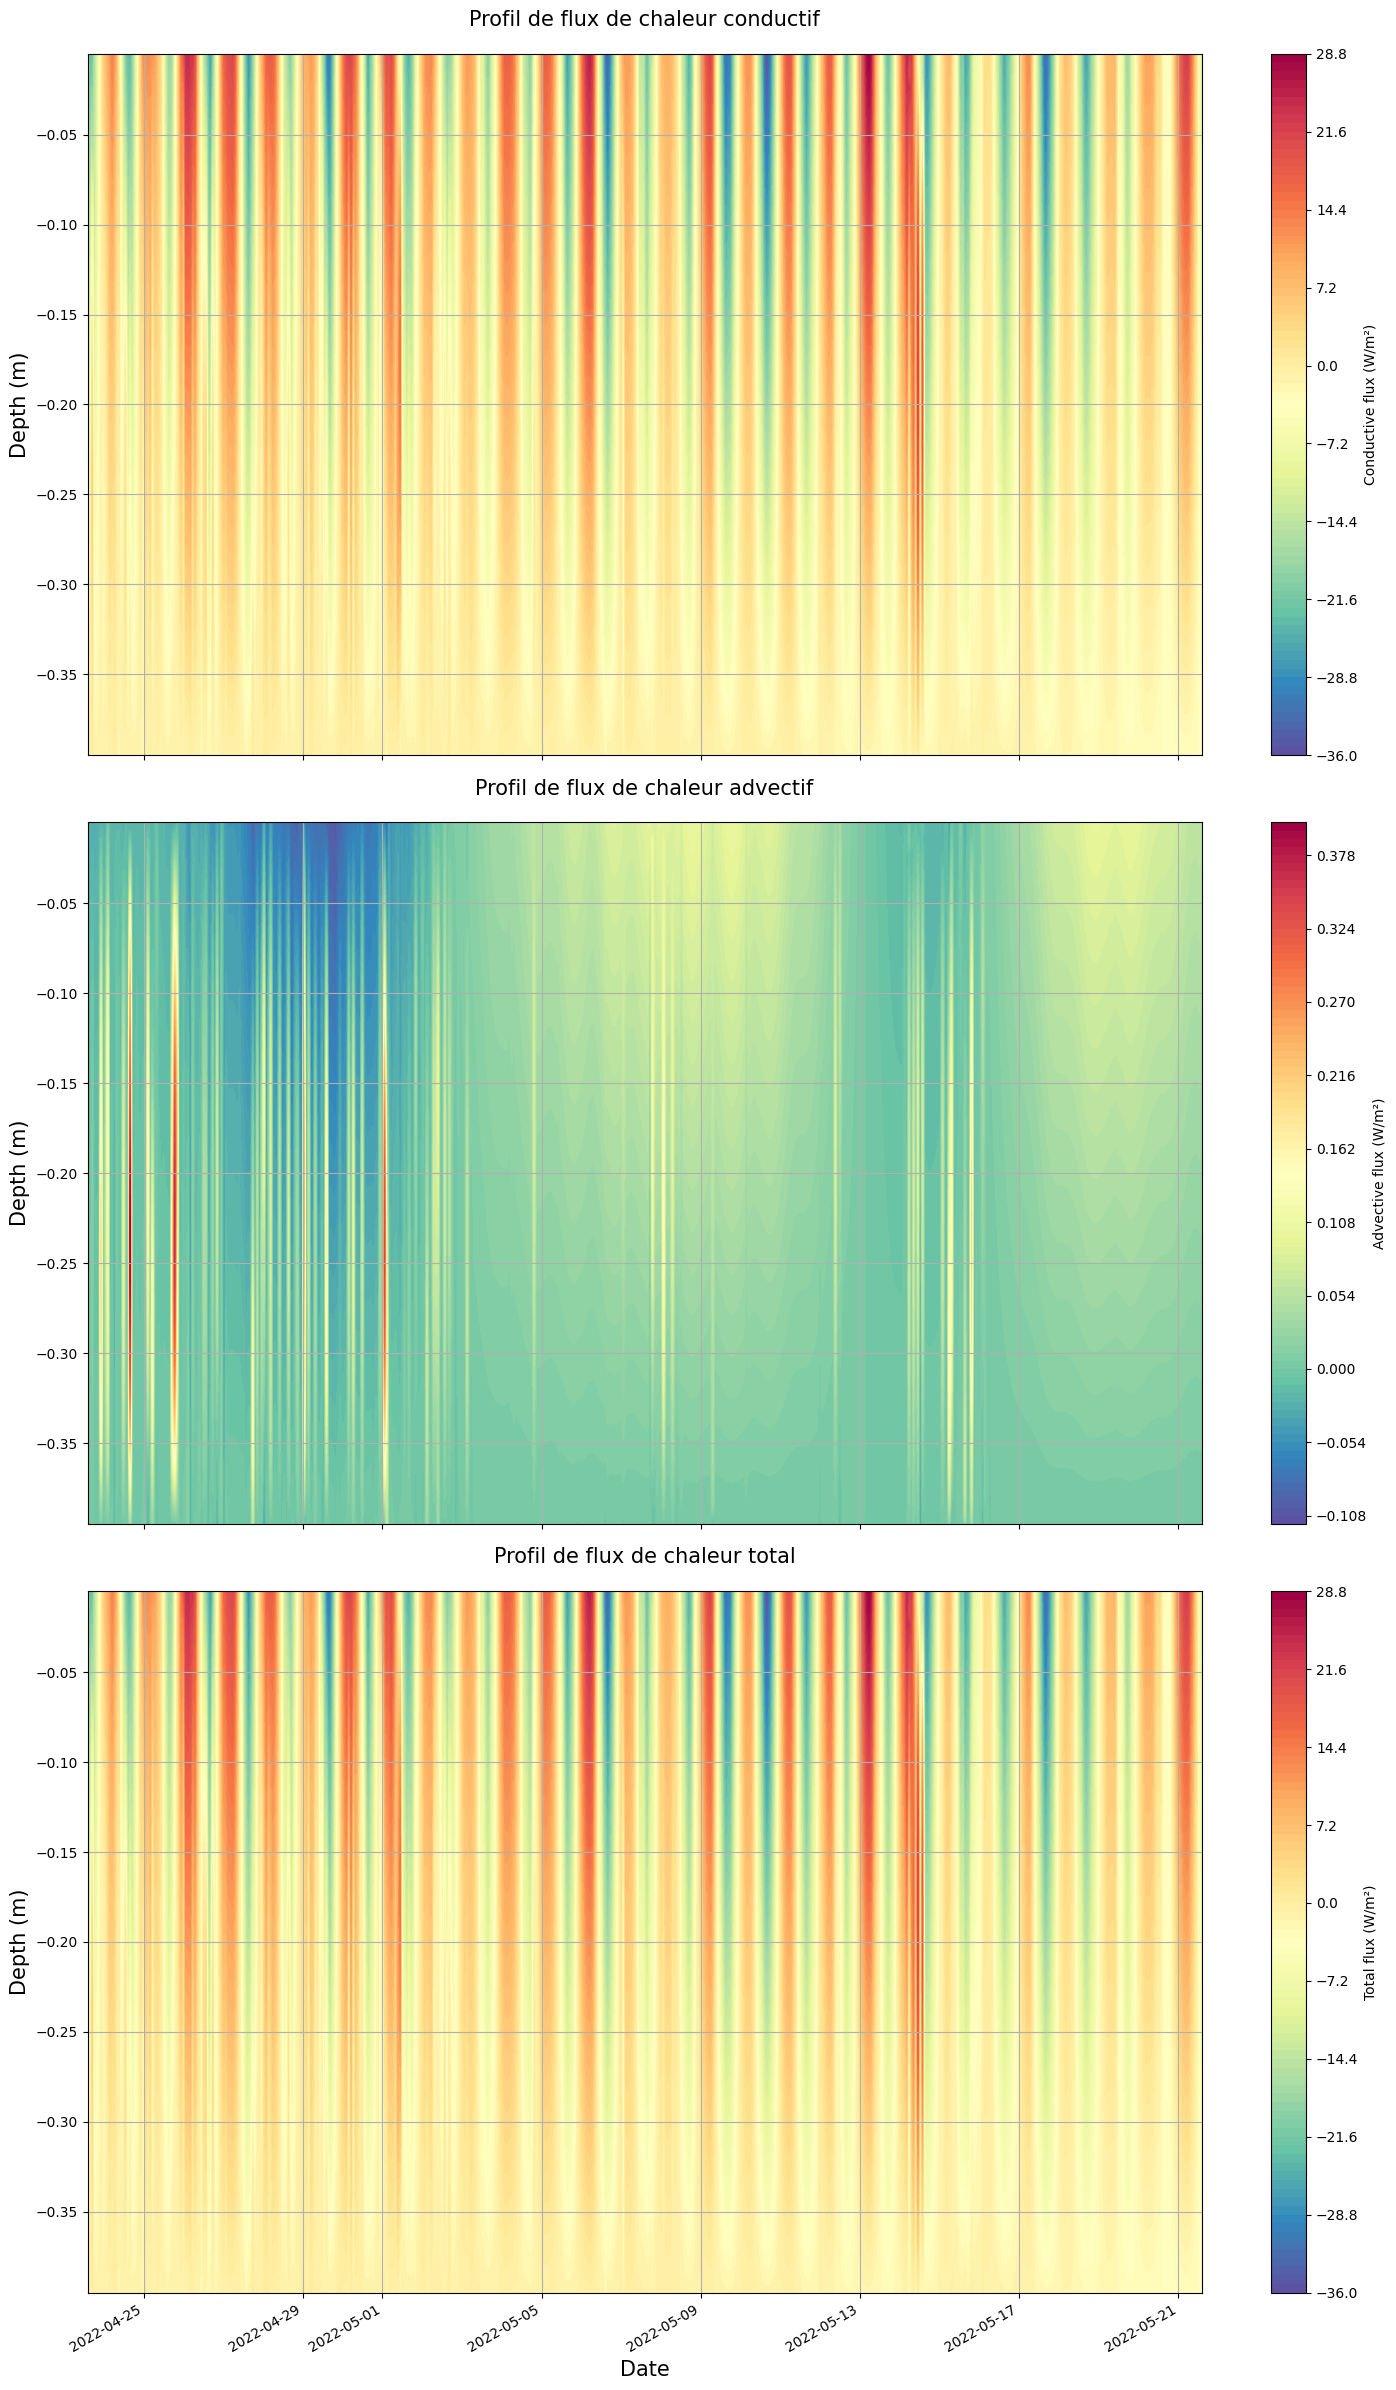

In [73]:
plot_heat_flux_profiles_interpolated(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

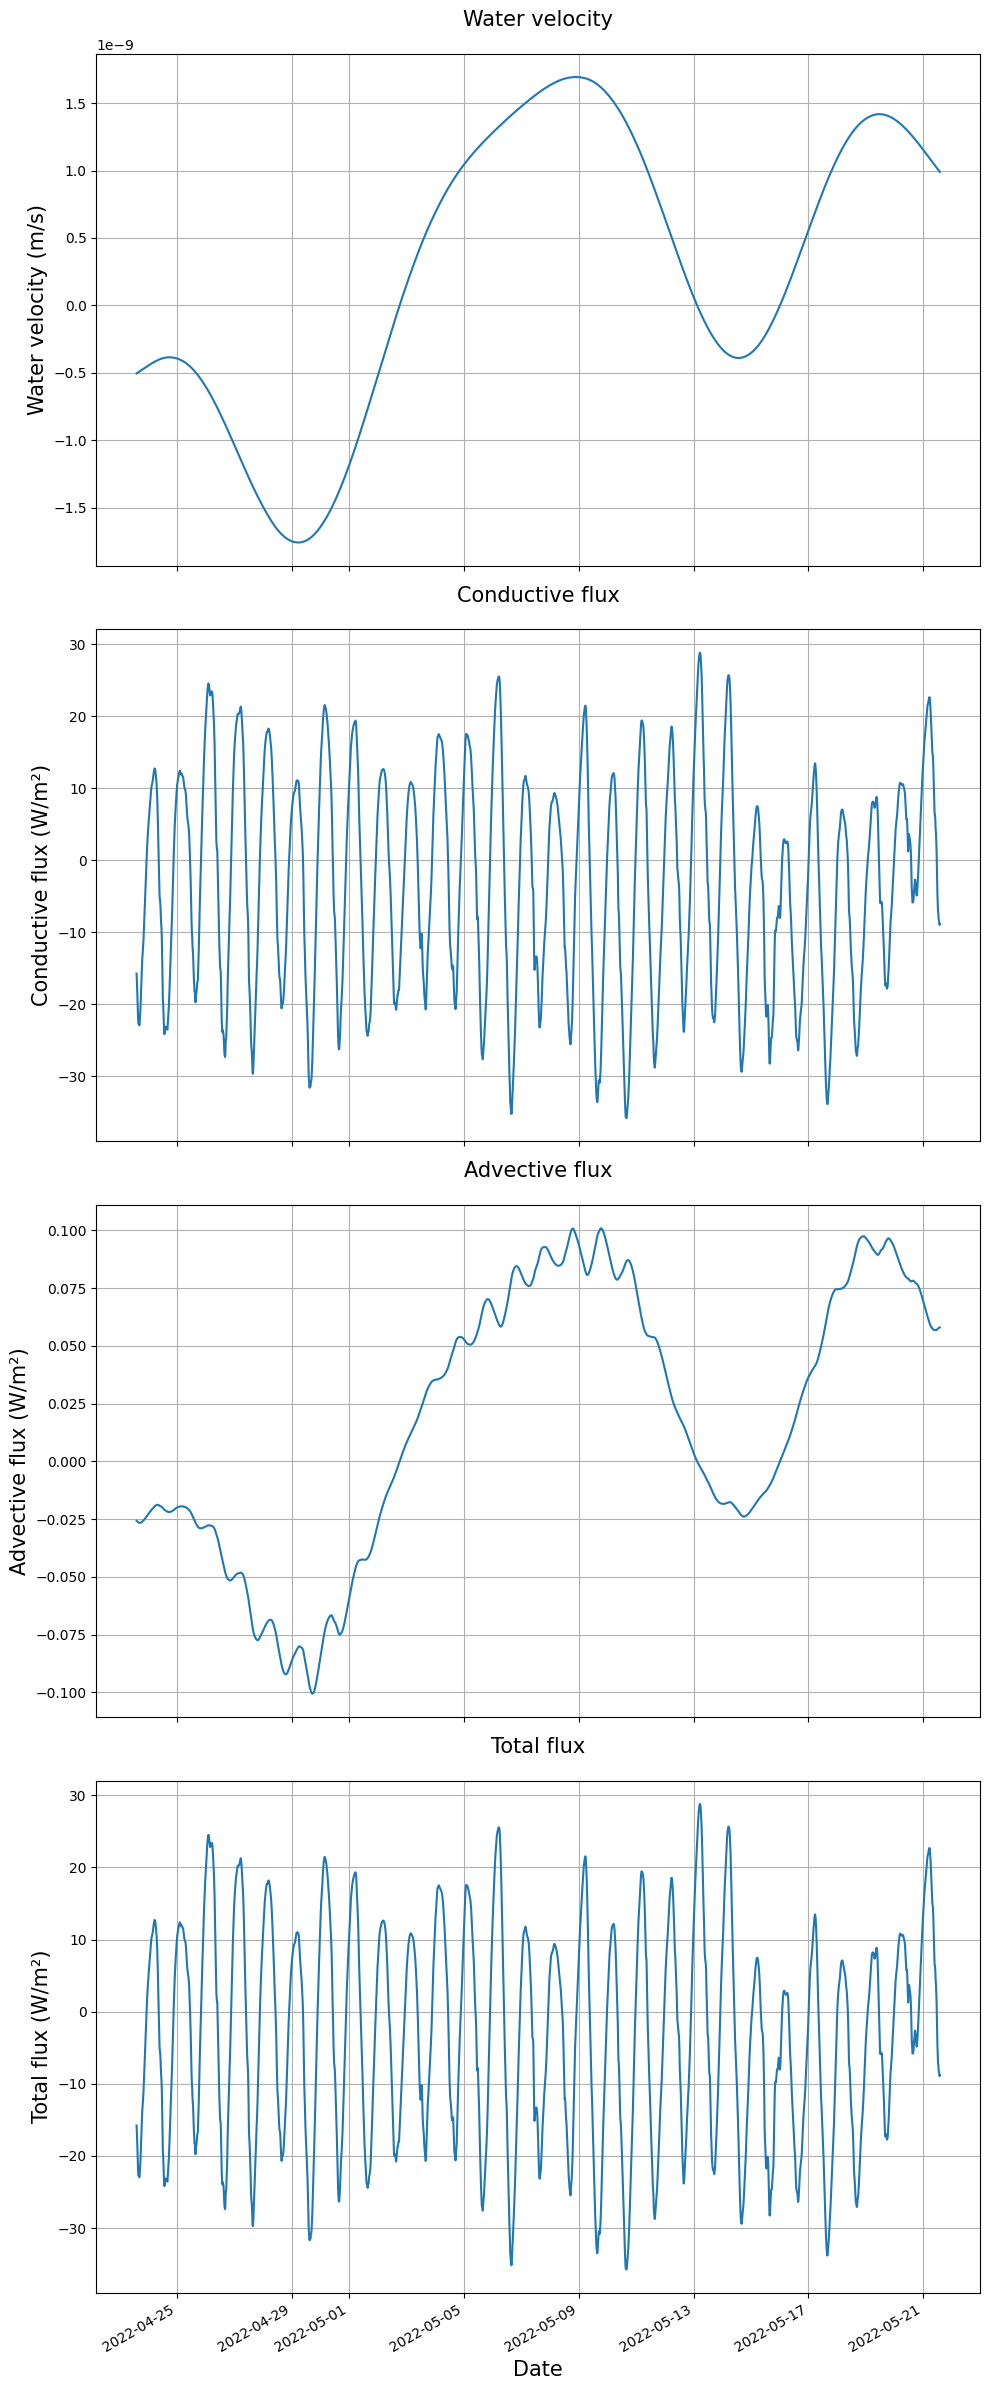

In [74]:
plot_fluxes_timeseries(date_simul_bg=pd.to_datetime("2022/04/21 14:00:00"))

# 3. ANALYSE DE SENSIBILITÉ - Influence de la Perméabilité sur les Échanges Nappe-Rivière

### **Objectifs Pédagogiques**

À travers cette analyse, vous allez :

- **Quantifier l'impact** de variations de perméabilité sur les échanges thermiques
- **Apprendre à interpréter** les résultats de simulations numériques
- **Développer un sens critique** sur l'incertitude des paramètres

### **Méthodologie d'Analyse**

Nous allons :
1. **Définir une gamme de perméabilités** représentatives des milieux naturels
2. **Exécuter des simulations multiples** avec différentes valeurs de $k$
3. **Analyser quantitativement** l'impact sur les flux d'eau et de chaleur
4. **Visualiser les relations** entre paramètres et réponses du modèle


### **Gamme de Perméabilités dans la Nature**

| Matériau | Perméabilité (m²) | Log₁₀(k) | Contexte |
|----------|-------------------|-----------|----------|
| Argile compacte | 10⁻²⁰ - 10⁻¹⁸ | -20 à -18 | Couche imperméable |
| Argile | 10⁻¹⁸ - 10⁻¹⁵ | -18 à -15 | Aquitard |
| Sable fin | 10⁻¹⁵ - 10⁻¹³ | -15 à -13 | Sédiments fins |
| Sable moyen | 10⁻¹³ - 10⁻¹¹ | -13 à -11 | Aquifère modéré |
| Gravier | 10⁻¹¹ - 10⁻⁹ | -11 à -9 | Aquifère productif |

### **Sédiments de Fond de Rivière**

Les sédiments de fond de rivière présentent typiquement :
- **Perméabilité élevée** en surface (dépôts récents, peu compactés)
- **Stratification** avec diminution de $k$ en profondeur
- **Hétérogénéité spatiale** importante
- **Variation temporelle** due au colmatage/décapage

##  Plan d'Expérience Numérique

### **Variables à Tester**

Nous allons faire varier la perméabilité sur **3 ordres de grandeur** :

- **k₁ = 10⁻¹⁶ m²** : Milieu peu perméable (sable argileux)
- **k₂ = 10⁻¹⁵ m²** : Configuration de référence (sable fin)
- **k₃ = 10⁻¹⁴ m²** : Milieu perméable (sable moyen)
- **k₄ = 10⁻¹³ m²** : Milieu très perméable (sable grossier)
- **k₅ = 10⁻¹² m²** : Milieu extrêmement perméable (gravier fin)

### **Variables de Sortie à Analyser**

1. **Flux d'eau verticaux** : Vitesse à l'interface nappe-rivière
2. **Signatures thermiques** : Amplitude et phase des signaux de température
3. **Flux de chaleur** : Composantes conductive et advective
4. **Métriques de performance** : Concordance avec les observations

### **Hypothèses à Vérifier**

- **H1** : L'augmentation de $k$ intensifie les échanges nappe-rivière
- **H2** : Une perméabilité plus élevée améliore le transport de chaleur advectif
- **H3** : L'effet de $k$ est non-linéaire et présente des seuils
- **H4** : La sensibilité dépend de la profondeur dans le sédiment

In [76]:
# =============================================================================
# ANALYSE DE SENSIBILITÉ À LA PERMÉABILITÉ
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Définir la gamme de perméabilités à tester (en échelle logarithmique)
print("="*80)
print("ANALYSE DE SENSIBILITÉ - PERMÉABILITÉ vs ÉCHANGES NAPPE-RIVIÈRE")
print("="*80)
print()

# Définir les valeurs de perméabilité à tester
permeability_values = {
    'k1_low': -16,      # 10^-16 m² : Sable argileux
    'k2_ref': -15,      # 10^-15 m² : Configuration de référence
    'k3_med': -14,      # 10^-14 m² : Sable moyen  
    'k4_high': -13,     # 10^-13 m² : Sable grossier
    'k5_very_high': -12 # 10^-12 m² : Gravier fin
}

print("GAMME DE PERMÉABILITÉS À TESTER:")
print("-" * 50)
for name, log_k in permeability_values.items():
    k_value = 10**log_k
    print(f"{name:<12}: log₁₀(k) = {log_k:2d}, k = {k_value:.2e} m²")

print()
print("MÉTHODOLOGIE:")
print("1. Exécution de simulations pour chaque valeur de k")
print("2. Extraction des flux d'eau et de chaleur")
print("3. Calcul des métriques de performance")
print("4. Analyse comparative et visualisation")
print()

# Préparer le stockage des résultats
sensitivity_results = {}
performance_metrics = {}

print("Démarrage de l'analyse de sensibilité...")
print("(Chaque simulation prend quelques minutes)")

ANALYSE DE SENSIBILITÉ - PERMÉABILITÉ vs ÉCHANGES NAPPE-RIVIÈRE

GAMME DE PERMÉABILITÉS À TESTER:
--------------------------------------------------
k1_low      : log₁₀(k) = -16, k = 1.00e-16 m²
k2_ref      : log₁₀(k) = -15, k = 1.00e-15 m²
k3_med      : log₁₀(k) = -14, k = 1.00e-14 m²
k4_high     : log₁₀(k) = -13, k = 1.00e-13 m²
k5_very_high: log₁₀(k) = -12, k = 1.00e-12 m²

MÉTHODOLOGIE:
1. Exécution de simulations pour chaque valeur de k
2. Extraction des flux d'eau et de chaleur
3. Calcul des métriques de performance
4. Analyse comparative et visualisation

Démarrage de l'analyse de sensibilité...
(Chaque simulation prend quelques minutes)


# 4 Sensibilité de la conductivité thermique